# Exploratory Data Analysis Notebook

## Setup

In [4]:
# Imports
import sys
import pandas as pd

if '..' not in sys.path:
    sys.path.insert(0, '..')
from src.loaders.config import Config
from src.loaders.database_helpers import get_engine

In [5]:
# Create config object
config = Config('../config')

# Database connection
url = 'sqlite+pysqlite:///../data/final/ranked_boardgames.sqlite3' 
# url = 'sqlite+pysqlite:///../data/final/boardgames.sqlite3'
db_connect = get_engine(url)

## Load Data

In [6]:
# Load tables to dataframes
df_games = pd.read_sql_table('game', db_connect, index_col='ID')
df_mechanics = pd.read_sql_table('mechanic', db_connect, index_col='ID')
df_categories = pd.read_sql_table('category', db_connect, index_col='ID')

game_mech_join = """
SELECT g.ID AS ID, Title, ReleaseYear, m.Name AS Mechanic
FROM game g
JOIN game_mechanic gm ON gm.GameID = g.ID
JOIN mechanic m ON m.ID = gm.MechanicID
"""
game_cat_join = """
SELECT g.ID AS ID, Title, ReleaseYear, c.Name AS Category
FROM game g
JOIN game_category gc ON gc.GameID = g.ID
JOIN category c ON c.ID = gc.CategoryID
"""
df_games_mech = pd.read_sql_query(game_mech_join, db_connect, index_col='ID')
df_games_cat = pd.read_sql_query(game_cat_join, db_connect, index_col='ID')

## EDA

### Games
There are 8 repeated titles. What are they and what is the difference between entries?

In [32]:
# Examine duplicate titles
duplicates = df_games['Title'].loc[df_games['Title'].duplicated()]
df_games.loc[df_games['Title'].isin(duplicates)].sort_values('Title')

,ID,Title,ReleaseYear,AvgRating,BayesRating,TotalRatings,StdRatings,MinPlayers,MaxPlayers,MinPlaytime,MaxPlaytime,Weight,OwnedCopies
30,98,Axis & Allies,1981,6.56433,6.28566,10649,1.57721,2,5,180,180,3.0381,15189
255,10093,Axis & Allies,2004,6.69396,6.31028,5950,1.59853,2,5,240,240,3.2146,7774
91,478,Citadels,2000,7.07591,6.96514,51340,1.26096,2,8,20,60,2.0527,68998
1342,205398,Citadels,2016,7.28893,6.95853,10432,1.25172,2,8,30,60,2.0192,19263
7,15,Cosmic Encounter,1977,6.91244,6.41563,3916,1.82543,2,6,90,90,2.3747,4363
486,39463,Cosmic Encounter,2008,7.53691,7.36264,29868,1.69842,3,5,60,120,2.5786,37170
40,121,Dune,1979,7.60963,7.04924,5666,1.68844,2,6,60,180,3.4515,6527
1798,283355,Dune,2019,8.04328,7.30463,5765,1.56480,2,6,120,180,3.9681,14177
417,31481,Galaxy Trucker,2007,7.37595,7.25149,31872,1.45031,2,4,60,60,2.3294,35559
1983,336794,Galaxy Trucker,2021,7.64900,6.54318,1760,1.20865,2,4,20,30,2.3953,5063


### Mechanics

In [47]:
# View df_mechanics
df_mechanics

,Name,Generic
ID,,
2073,acting,acting
2838,action-drafting,action
2001,action-points,action
2689,action-queue,action
2839,action-retrieval,action
...,...,...
2017,voting,voting
2082,worker-placement,worker-placement
2935,worker-placement-dice-workers,worker-placement


A few general mechanics have multiple sub-types:
- auction
- action
- worker-placement
- turn-order

It may be worth considering combining them into more general mechanic groups.

In [7]:
# Get counts of generic mechanic types
for generic in ['action', 'auction', 'worker-placement', 'turn-order']:
    print(generic, df_mechanics.Name.str.contains(generic).sum())

action 9
auction 13
worker-placement 3
turn-order 8


In [34]:
# Examine the number of games in each 'generic' mechanism sub-type
for gen_mech in ['action', 'auction', 'worker-placement', 'turn-order']:
    mask = df_mechanics.Name.str.contains(gen_mech)
    mechanics_set = df_mechanics[mask].Name.to_list()
    for mech in mechanics_set:
        print(mech, df_games_mech['Title'].loc[df_games_mech['Mechanic'] == mech].count())
    print()

action-drafting 29
action-points 219
action-queue 71
action-retrieval 43
action-timer 3
actionevent 12
passed-action-token 1
simultaneous-action-selection 160
turn-order-claim-action 42

auction-compensation 1
auctionbidding 157
auction-dexterity 0
auction-dutch 11
auction-dutch-priority 5
auction-english 1
auction-fixed-placement 8
auction-once-around 10
auction-sealed-bid 10
auction-turn-order-until-pass 11
closed-economy-auction 5
multiple-lot-auction 5
turn-order-auction 10

worker-placement 234
worker-placement-dice-workers 38
worker-placement-different-worker-types 38

auction-turn-order-until-pass 11
turn-order-auction 10
turn-order-claim-action 42
turn-order-pass-order 15
turn-order-progressive 50
turn-order-random 4
turn-order-role-order 8
turn-order-stat-based 31



In [14]:
def make_generic(mechanic: str) -> str:
    '''Condense mechanics to fewer types'''
    if 'action' in mechanic:
        return 'action'
    elif 'auction' in mechanic:
        return 'auction'
    elif 'worker-placement' in mechanic:
        return 'worker-placement'
    elif 'turn-order' in mechanic:
        return 'turn-order'
    else:
        return mechanic

In [42]:
# Apply generic mechanic labels to df_mechanics
df_mechanics['Generic'] = df_mechanics['Name'].apply(make_generic)
df_mechanics

,Name,Generic
ID,,
2073,acting,acting
2838,action-drafting,action
2001,action-points,action
2689,action-queue,action
2839,action-retrieval,action
...,...,...
2017,voting,voting
2082,worker-placement,worker-placement
2935,worker-placement-dice-workers,worker-placement


In [43]:
# Apply generic mechanic labels to df_games_mech
df_games_mech['Generic'] = df_games_mech['Mechanic'].apply(make_generic)
df_games_mech['Generic'].value_counts()

hand-management           708
dice-rolling              624
action                    580
variable-player-powers    571
set-collection            430
                         ... 
player-judge                2
physical-removal            2
induction                   1
matching                    1
singing                     1
Name: Generic, Length: 156, dtype: int64

### Categories

In [48]:
# View categories
df_categories

,Name
ID,
1009,abstract-strategy
1032,action-dexterity
1022,adventure
2726,age-reason
1048,american-civil-war
...,...
1019,wargame
1025,word-game
1065,world-war-i


In [106]:
# Value counts of Categories
df_games_cat['Category'].value_counts()

card-game              539
fantasy                415
economic               322
fighting               268
science-fiction        238
                      ... 
expansion-base-game      3
music                    2
vietnam-war              2
game-system              1
korean-war               1
Name: Category, Length: 83, dtype: int64

In [49]:
# Counts of categories with 'war' in name
df_games_cat.loc[df_games_cat['Category'].str.contains('war')]['Category'].value_counts()

wargame                       196
world-war-ii                   62
modern-warfare                 14
civil-war                      11
american-indian-wars            8
american-civil-war              7
world-war-i                     7
american-revolutionary-war      6
vietnam-war                     2
korean-war                      1
Name: Category, dtype: int64

In [115]:
print('Contain "war":', len(df_games_cat.loc[df_games_cat['Category'].str.contains('war')].groupby('Title')))

print("Not wargame:", len(df_games_cat.loc[(df_games_cat['Category'].str.contains('war')) & (df_games_cat['Category'] != 'wargame')].groupby('Title')))

print("wargame:", len(df_games_cat.loc[df_games_cat['Category'] == 'wargame']))

Contain "war": 206
Not wargame: 107
wargame: 196


In [8]:
df_games.corr()

,ReleaseYear,AvgRating,BayesRating,TotalRatings,StdRatings,MinPlayers,MaxPlayers,MinPlaytime,MaxPlaytime,Weight,OwnedCopies
ReleaseYear,1.000000,0.080100,0.055774,0.009097,-0.059273,-0.010995,-0.009415,0.004835,0.008978,0.040643,0.014047
AvgRating,0.080100,1.000000,0.469806,0.168055,-0.303936,-0.176986,-0.042931,0.040686,0.097230,0.486298,0.176461
BayesRating,0.055774,0.469806,1.000000,0.635588,-0.269543,-0.087083,-0.021034,0.004682,0.017482,0.285384,0.641415
TotalRatings,0.009097,0.168055,0.635588,1.000000,-0.108540,-0.014311,-0.002489,-0.004387,-0.004455,0.086611,0.985183
StdRatings,-0.059273,-0.303936,-0.269543,-0.108540,1.000000,0.041485,0.043930,0.036059,0.034338,-0.001925,-0.112762
MinPlayers,-0.010995,-0.176986,-0.087083,-0.014311,0.041485,1.000000,0.075724,0.042266,0.014355,-0.176509,-0.024865
MaxPlayers,-0.009415,-0.042931,-0.021034,-0.002489,0.043930,0.075724,1.000000,-0.006712,-0.008606,-0.091585,-0.001978
MinPlaytime,0.004835,0.040686,0.004682,-0.004387,0.036059,0.042266,-0.006712,1.000000,0.850048,0.126539,-0.003942
MaxPlaytime,0.008978,0.097230,0.017482,-0.004455,0.034338,0.014355,-0.008606,0.850048,1.000000,0.184614,-0.002754
Weight,0.040643,0.486298,0.285384,0.086611,-0.001925,-0.176509,-0.091585,0.126539,0.184614,1.000000,0.087415


<AxesSubplot:xlabel='ReleaseYear', ylabel='BayesRating'>

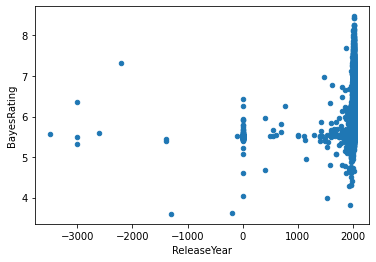

In [16]:
df_games.plot(kind='scatter', x='ReleaseYear', y='BayesRating')